In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from pprint import pprint
import yfinance as yf
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)


# Getting the Data

In [2]:
ativos = ['ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'PETR3.SA', 'VALE3.SA']
num_ativos = len(ativos)
csv_file_path = "data/stock_data.csv"

if not pathlib.Path(csv_file_path).exists():
    stock_data = yf.download(ativos, start="2020-01-01", end="2025-01-01", group_by="ticker")
    stock_data.to_csv(csv_file_path, index=True)
else:
    stock_data = pd.read_csv(csv_file_path, header=[0, 1], index_col=0)

price_data_frame = stock_data.xs('Adj Close', axis=1, level=1)

price_data_frame.head()



Ticker,ABEV3.SA,PETR3.SA,ITUB4.SA,VALE3.SA,BBDC4.SA
Date,,,,,
2020-01-02,16.175148,11.703511,31.228830,36.413361,22.384174
2020-01-03,15.947685,11.414492,30.900372,36.145264,22.395496
2020-01-06,16.023504,11.785577,30.440514,35.930790,21.995480
2020-01-07,16.057205,11.625012,29.734314,36.192177,21.613344
2020-01-08,15.981383,11.435903,29.249830,36.198883,21.279007


# Using Sharpe Ratio as a metric

Using the Sharpe Ratio to determine which portfolio has a better risk/return

Mathematically, we define the Sharpe Ratio as the following:

$$
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
$$

Where:

$$
\begin{align}
R_p & = \text{Return of Portfolio} \\
R_f & = \text{Risk-Free Rate} \\
\sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$$

To calculate the expected returns, we use the following formula:

$$
R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
$$

Where:

$$
\begin{align}
r_{i} & = \text{Return of Security i} \\
w_{i} & = \text{Weight of Security i} \\
\end{align}
$$

To calculate the standard deviation of the portfolio, we use the following formula:

$$
\sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
$$

Where:

$$
\begin{align}
\sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
w_{i} & = \text{Weight of Security i} \\
p_{i,j} & = \text{Correlation Coefficient between the returns of asset i and asset j} \\
\end{align}
$$


In [3]:
log_return = np.log(1+price_data_frame.pct_change())

# random weights
pesos_aleatorios = np.array(np.random.random(num_ativos))

# Rebancing the weights so that they sum up to 1
pesos_aleatorios_rebal = pesos_aleatorios / np.sum(pesos_aleatorios)

# Return, by year
retorno_esperado = np.sum((log_return.mean() * pesos_aleatorios_rebal) * 252)

# Volatility, by year
volatilidade_esperada = np.sqrt(np.dot(pesos_aleatorios_rebal.T, np.dot(log_return.cov() * 252, pesos_aleatorios_rebal)))

# Calculate Sharpe Ratio
sharpe_ratio = retorno_esperado / volatilidade_esperada

In [4]:
# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': pesos_aleatorios,
'rebalance_weights': pesos_aleatorios_rebal
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': retorno_esperado,
    'Expected Portfolio Volatility': volatilidade_esperada,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.390171           0.158000
1        0.080424           0.032568
2        0.546682           0.221379
3        0.793495           0.321326
4        0.658667           0.266727
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.004634                       0.283838                0.016326
--------------------------------------------------------------------------------


# Running Monte Carlo Simulation for random weights

In [5]:
# Decide the number of simulations
num_simulations = 10000

# Weights array
all_weights = np.zeros((num_simulations, num_ativos))

# Return array
ret_arr = np.zeros(num_simulations)

# Volatility array
vol_arr = np.zeros(num_simulations)

# Start the simulation
for i in range(num_simulations):
    # Weights
    pesos = np.array(np.random.random(num_ativos))
    pesos = pesos / np.sum(pesos)
    
    # Save the weights
    all_weights[i, :] = pesos
    
    # Expected Return
    ret_arr[i] = np.sum((log_return.mean() * pesos) * 252)
    
    # Expected Volatility
    vol_arr[i] = np.sqrt(np.dot(pesos.T, np.dot(log_return.cov() * 252, pesos)))
    
    # Sharpe Ratio
    sharpe_ratio = ret_arr / vol_arr
    
# Combine them all
simulation_data = [ret_arr, vol_arr, sharpe_ratio, all_weights]

simulation_df = pd.DataFrame(data=simulation_data).T

# Give the columns the Proper Names.
simulation_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulation_df = simulation_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulation_df.head())
print('-'*80)
    

C:\Users\guiga\AppData\Local\Temp\ipykernel_23464\220504968.py:29: RuntimeWarning: invalid value encountered in divide
  sharpe_ratio = ret_arr / vol_arr



SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                                            Portfolio Weights
0 -0.008704    0.284924     -0.030549        [0.2492705324762021, 0.0807823277734902, 0.07633939640576069, 0.2537492746635081, 0.3398584686810389]
1  0.049731    0.294329      0.168964      [0.14486366788391858, 0.1902622254945944, 0.26733171414768914, 0.2200253892236834, 0.17751700325011452]
2  0.063579    0.315878      0.201279       [0.2704172704458565, 0.3537570119687351, 0.03000095511453671, 0.11905031199254253, 0.2267744504783291]
3 -0.041307    0.301351     -0.137072  [0.33244590358363824, 0.11049987231196276, 0.17114820696878527, 0.0018348520323017876, 0.38407116510331196]
4  0.111893    0.319149      0.350598     [0.09693252781185181, 0.29702882198949215, 0.08809008233161678, 0.4084970746404626, 0.10945149322657656]
----------------

In [6]:
# Grab the max Sharpe Ratio
max_sharpe_ratio = simulation_df.loc[simulation_df['Sharpe Ratio'].idxmax()]

# Grab the min Volatility
min_volatility = simulation_df.loc[simulation_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                                                                                0.220093
Volatility                                                                                                             0.409844
Sharpe Ratio                                                                                                           0.537016
Portfolio Weights    [0.02624970558675501, 0.7067494394868442, 0.009515468844550262, 0.23068608869430673, 0.026799297387543712]
Name: 4487, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                                                                             -0.002618
Volatility                                               

# Making the efficient frontier graph

C:\Users\guiga\AppData\Local\Temp\ipykernel_23464\2956735269.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\guiga\AppData\Local\Temp\ipykernel_23464\2956735269.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\guiga\AppData\Local\Temp\ipykernel_23464\2956735269.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_volatility[1],
C:\Users\guiga\AppData\Local\Temp

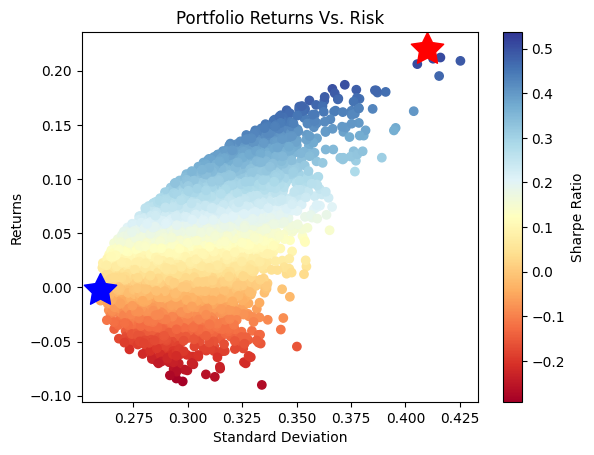

In [7]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulation_df['Returns'],
    x=simulation_df['Volatility'],
    c=simulation_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

# Optimization using Scipy Optimize

In [8]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

## Optimized Sharpe

In [9]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(num_ativos))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = num_ativos * [1 / num_ativos]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.34478250312984
       x: [ 3.477e-01  0.000e+00  0.000e+00  0.000e+00  6.523e-01]
     nit: 6
     jac: [ 3.226e-05  1.167e+00  3.415e-01  5.358e-01 -1.720e-05]
    nfev: 36
    njev: 6
--------------------------------------------------------------------------------


In [10]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.34768682 0.         0.         0.         0.65231318]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.11050453  0.32050505 -0.3447825 ]
--------------------------------------------------------------------------------


## Optimized Volatility

In [11]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(num_ativos))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = num_ativos * [1 / num_ativos]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.25699983446500463
       x: [ 4.784e-01  1.388e-17  2.448e-01  2.768e-01  0.000e+00]
     nit: 8
     jac: [ 2.573e-01  2.941e-01  2.570e-01  2.565e-01  2.781e-01]
    nfev: 48
    njev: 8
--------------------------------------------------------------------------------


In [12]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[4.78381213e-01 1.38777878e-17 2.44834245e-01 2.76784542e-01
 0.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[-0.00055667  0.25699983 -0.00216602]
--------------------------------------------------------------------------------
